# Exploration of the .skeleton files provided in the NTU-RGB-D dataset

S : setup number 
C : camera id
P : performer id
R : replication number
A : action label

In [1]:
%matplotlib notebook
import numpy as np
import os
import random

import ffmpeg
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from joints import *
from utils import *
from play_skeleton import *

ntu_path = "/media/gnocchi/Seagate Backup Plus Drive/NTU-RGB-D/"

rgb_folder = "nturgb+d_rgb/"
skeleton_folder = "nturgb+d_skeletons/"

sample_name = os.path.splitext(random.choice(os.listdir(ntu_path + skeleton_folder)))[0]
print(sample_name)
# sample_name = "S016C003P008R002A059"
# sample_name = "S001C001P001R001A001"
# sample_name = "S002C003P007R001A060"
# sample_name = "S001C003P003R001A060"
# sample_name = "S001C003P008R002A027"

S008C002P033R002A054


## Skeleton numpy array

read_xyz(...) returns a (3, max_frame, num_joint=25, 2) numpy array

read_color_xy(...) returns (2, max_frame, num_joint=25, 2) numpy array

In [2]:
skeleton = read_xyz(ntu_path + skeleton_folder + sample_name + ".skeleton") # shape (3, 103, 25, 2)

print("===== 3D skeleton =====")
print(skeleton[:, 0, :, 0])
print(skeleton.transpose(3, 2, 0, 1)[0].shape)

print("\r\n===== 2D RGB skeleton =====")
skeleton_2d = read_color_xy(ntu_path + skeleton_folder + sample_name + ".skeleton")
print(skeleton_2d[:, 0, :, 0])

has_2_subjects = np.any(skeleton_2d[:, :, :, 1])
print("Number of subjects : " + str(int(has_2_subjects) * 2))

===== 3D skeleton =====
[[ 0.364  0.349  0.337  0.337  0.233  0.227  0.216  0.246  0.319  0.238
   0.202  0.216  0.341  0.488  0.489  0.4    0.379  0.375  0.386  0.299
   0.34   0.249  0.231  0.223  0.231]
 [-0.489 -0.197  0.09   0.194 -0.082 -0.269 -0.517 -0.571 -0.033 -0.239
  -0.438 -0.479 -0.488 -0.781 -1.041 -1.074 -0.48  -0.796 -1.052 -1.085
   0.019 -0.61  -0.573 -0.52  -0.457]
 [ 2.762  2.764  2.752  2.765  2.909  2.672  2.707  2.716  2.66   2.583
   2.669  2.704  2.729  2.842  2.865  2.806  2.732  2.758  2.768  2.709
   2.757  2.719  2.716  2.712  2.681]]
(25, 3, 46)

===== 2D RGB skeleton =====
[[1115.384  1109.185  1104.498  1103.905  1058.753  1066.105  1060.612
  1071.822  1103.008  1074.312  1056.326  1060.491  1108.4    1157.481
  1156.475  1127.384  1123.014  1120.268  1124.195  1093.743  1105.521
  1073.266  1065.996  1062.971  1067.565 ]
 [ 726.4551  614.4631  503.9207  464.3273  568.8787  645.5155  741.557
   761.9305  551.901   636.88    712.6744  726.767   728.1927

## Skeleton animation

In [3]:
# animateJointCoordinates(skeleton.transpose(3, 2, 0, 1)[0], connexion_tuples)

## Video playback with hand tracking for 1 or 2 subjects

Creates a video object of size (seq_len, 1080, 1920, 3)

In [4]:
probe = ffmpeg.probe(ntu_path + rgb_folder + sample_name + '_rgb.avi')
video_info = next(x for x in probe['streams'] if x['codec_type'] == 'video')
width = int(video_info['width'])
height = int(video_info['height'])
num_frames = int(video_info['nb_frames'])
print(num_frames)

46


In [5]:
out, err = (ffmpeg
           .input(ntu_path + rgb_folder + sample_name + '_rgb.avi')
           .output('pipe:', format='rawvideo', pix_fmt='rgb24')
           .run(capture_stdout=True)
)
video = np.frombuffer(out, np.uint8).reshape([-1, height, width, 3])
print(video.shape)

(46, 1080, 1920, 3)


<IPython.core.display.Javascript object>


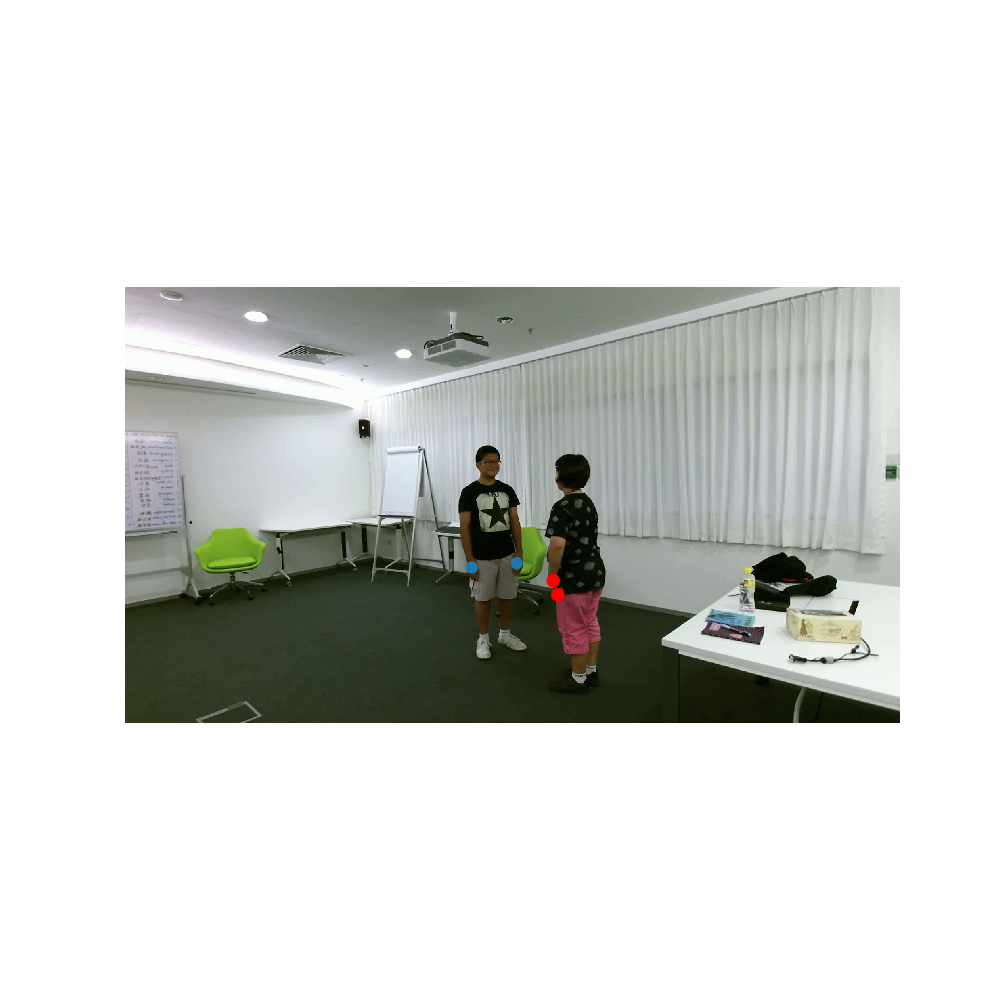

In [6]:
f = plt.figure()
ax = f.gca()
f.set_size_inches(10,10)

image = plt.imshow(video[0], interpolation='None', animated = True)

# skeleton_2d shape (2{xy}, max_frame, num_joint=25, 2)
right_hand_s1 = Circle((skeleton_2d[0, 0, Joints.HANDRIGHT, 0], skeleton_2d[1, 0, Joints.HANDRIGHT, 0]),15, color="red")
left_hand_s1 = Circle((skeleton_2d[0, 0, Joints.HANDLEFT, 0], skeleton_2d[1, 0, Joints.HANDLEFT, 0]),15, color="red")

ax.add_patch(right_hand_s1)
ax.add_patch(left_hand_s1)

if has_2_subjects:
    right_hand_s2 = Circle((skeleton_2d[0, 0, Joints.HANDRIGHT, 1], skeleton_2d[1, 0, Joints.HANDRIGHT, 1]),15)
    left_hand_s2 = Circle((skeleton_2d[0, 0, Joints.HANDLEFT, 1], skeleton_2d[1, 0, Joints.HANDLEFT, 1]),15)
    
    ax.add_patch(right_hand_s2)
    ax.add_patch(left_hand_s2)



plt.axis('off')


def videoAnimation(frame_index):
    image.set_data(video[frame_index])
    [p.remove() for p in ax.patches]
    right_hand_s1 = Circle((skeleton_2d[0, frame_index, Joints.HANDRIGHT, 0], skeleton_2d[1, frame_index, Joints.HANDRIGHT, 0]),15, color='red')
    left_hand_s1 = Circle((skeleton_2d[0, frame_index, Joints.HANDLEFT, 0], skeleton_2d[1, frame_index, Joints.HANDLEFT, 0]),15, color='red')
    
    ax.add_patch(right_hand_s1)
    ax.add_patch(left_hand_s1)
    
    if has_2_subjects:
        right_hand_s2 = Circle((skeleton_2d[0, frame_index, Joints.HANDRIGHT, 1], skeleton_2d[1, frame_index, Joints.HANDRIGHT, 1]),15)
        left_hand_s2 = Circle((skeleton_2d[0, frame_index, Joints.HANDLEFT, 1], skeleton_2d[1, frame_index, Joints.HANDLEFT, 1]),15)

        ax.add_patch(right_hand_s2)
        ax.add_patch(left_hand_s2)
    
    return image,

ani = animation.FuncAnimation(f, videoAnimation, interval = 200, frames = num_frames, repeat = False)


## Crop around the hands

According to "Pose-conditioned Spatio-Temporal Attention for Human Action Recognition" https://arxiv.org/pdf/1703.10106.pdf, the crops are 50x50p around hands on NTU dataset. The same cropping dimensions are kept on latter paper STA-Hands by same author.


In [7]:
hand_crops = extract_hands(skeleton_2d, video, crop_size) # shape (n_frames, 4, crop_size, crop_size, 3)
if hand_crops.shape[1] == 2:
    pad = np.zeros(hand_crops.shape, dtype=hand_crops.dtype)
    hand_crops = np.concatenate((hand_crops, pad), axis = 1)


<IPython.core.display.Javascript object>


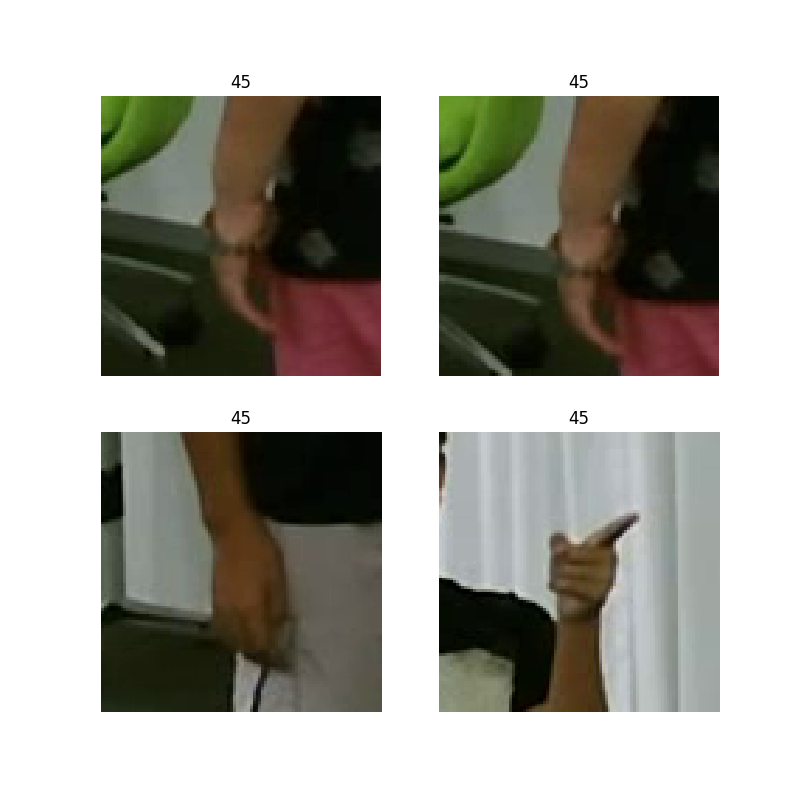

In [8]:
# Using video for variable from above of shape (seq_len, 1080, 1920, 3)
f, (axs) = plt.subplots(2, 2)
f.set_size_inches(8, 8)
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')

s1_l = axs[0, 0].imshow(hand_crops[0, 0])
s1_r = axs[0, 1].imshow(hand_crops[0, 1])
s2_l = axs[1, 0].imshow(hand_crops[0, 2])
s2_r = axs[1, 1].imshow(hand_crops[0, 3])


def videoAnimation(frame_index):
    s1_l.set_data(hand_crops[frame_index, 0])
    s1_r.set_data(hand_crops[frame_index, 1])
    s2_l.set_data(hand_crops[frame_index, 2])
    s2_r.set_data(hand_crops[frame_index, 3])
    
    axs[0, 0].set_title(frame_index)
    axs[0, 1].set_title(frame_index)
    axs[1, 0].set_title(frame_index)
    axs[1, 1].set_title(frame_index)
    
    
    return s1_l

ani = animation.FuncAnimation(f, videoAnimation, interval = 200, frames = num_frames, repeat = False)